# Network in Network

This notebook is an implement of [___Network In Network___](https://arxiv.org/pdf/1312.4400.pdf) by Lin et al. We train the model on Cifar-10 dataset, which is a relatively small dataset compared to others like ImageNet and thus is easier to train.

We first need to install and import all the dependent libraries in the session.

In [1]:
# For pip users
# ! pip install -r ../requirements.txt
# For conda users
! conda install --file ../requirements.txt -y

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from utilities import getCifar
from utilities import show_training_accuracy, show_Cifar_validation_result

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Solving environment: done

# All requested packages already installed.



2022-06-27 13:03:02.495348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11819 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0004:05:00.0, compute capability: 7.0


In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set validation set, and test set.

In [2]:
batch_size = 64

train, val, test = getCifar(batch_size)

2022-06-27 13:03:03.835479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11819 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0004:05:00.0, compute capability: 7.0


This is function that constructs a NiN model. The structure of the model is almost same with the original paper, but we add some preprocessing to make the network better fits Cifar 10 dataset. We define ```weight_decay``` as the hyperparameters of the model for kernel regularization. In addtion, we also apply data augmentation to original images to reduce overfitting.

In [3]:
def NiN_block(input, kernel_size, filters, stride, weight_decay):
    x = Conv2D(kernel_size = kernel_size, filters = filters, strides = stride, padding = "same", kernel_regularizer = l2(weight_decay))(
        input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(kernel_size = 1, filters = filters, kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(kernel_size = 1, filters = filters, kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def createNiN(weight_decay):
    input = Input(shape = (32, 32, 3))

    # Data augmentation
    x = Resizing(224, 224)(input)
    x = RandomRotation(.1)(x)
    x = RandomFlip("horizontal")(x)
    x = RandomContrast(.3)(x)
    x = RandomTranslation((-.3, .3), (-.3, .3))(x)

    x = NiN_block(x, 11, 96, 4, weight_decay)
    x = MaxPooling2D(3, strides = 2)(x)
    x = NiN_block(x, 5, 256, 1, weight_decay)
    x = MaxPooling2D(3, strides = 2)(x)
    x = NiN_block(x, 3, 384, 1, weight_decay)
    x = MaxPooling2D(3, 2)(x)
    x = NiN_block(x, 3, 10, 1, weight_decay)
    x = GlobalAveragePooling2D()(x)
    x = Activation(tf.nn.softmax)(x)

    model = tf.keras.Model(inputs = input, outputs = x, name = "NiN")

    return model

This part trains the NiN model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on drive so that we can continue training even if the session disconnects. We also store searching results and training weights in case the process takes too much time or the session crashes accidentally. We show the result of the training process with a graph about the training and validation accuracy for each epoch. The training result could vary due to randomness created by file shuffling and learning rate. This problem will be fixed soon.

Epoch 1/150


2022-06-27 13:03:07.273999: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8101" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 12393709568 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-06-27 13:03:07.869522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


625/625 [==============================] - ETA: 0s - loss: 3.7916 - accuracy: 0.3510

2022-06-27 13:03:32.867477: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8101" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 12393709568 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


625/625 [==============================] - 29s 41ms/step - loss: 3.7916 - accuracy: 0.3510 - val_loss: 3.5595 - val_accuracy: 0.3742 - lr: 1.0000e-04
Epoch 2/150
625/625 [==============================] - 25s 40ms/step - loss: 3.2930 - accuracy: 0.4472 - val_loss: 3.1039 - val_accuracy: 0.4279 - lr: 1.0000e-04
Epoch 3/150
625/625 [==============================] - 25s 40ms/step - loss: 2.9396 - accuracy: 0.4947 - val_loss: 2.8098 - val_accuracy: 0.4754 - lr: 1.0000e-04
Epoch 4/150
625/625 [==============================] - 25s 40ms/step - loss: 2.6623 - accuracy: 0.5318 - val_loss: 2.6891 - val_accuracy: 0.4648 - lr: 1.0000e-04
Epoch 5/150
625/625 [==============================] - 25s 40ms/step - loss: 2.4425 - accuracy: 0.5606 - val_loss: 2.3028 - val_accuracy: 0.5572 - lr: 1.0000e-04
Epoch 6/150
625/625 [==============================] - 26s 41ms/step - loss: 2.2751 - accuracy: 0.5819 - val_loss: 2.2465 - val_accuracy: 0.5582 - lr: 1.0000e-04
Epoch 7/150
625/625 [===================

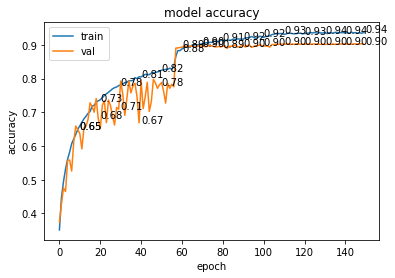

In [4]:
# Callbacks for training
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "val_loss", verbose = 0, save_best_only = True, mode = "auto")
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 10, verbose = 0, 
                                          mode = 'auto', min_delta = 0.0001, cooldown = 5, min_lr = 1e-10)
es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)

# Hyperparameters
weight_decay = 1e-3
learning_rate = 1e-4

# Create ResNet-50 model
model = createNiN(weight_decay)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights") 

# Training
history = model.fit(train, epochs = 150, validation_data = val, callbacks = [lr, es])

show_training_accuracy(history)

Here we test our model on test set and show how NiN predicts on sample images in the test set.

157/157 [==============================] - 2s 12ms/step - loss: 0.5657 - accuracy: 0.9000
Test Accuracy: 90.00%


2022-06-27 14:06:35.265179: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8101" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 12393709568 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


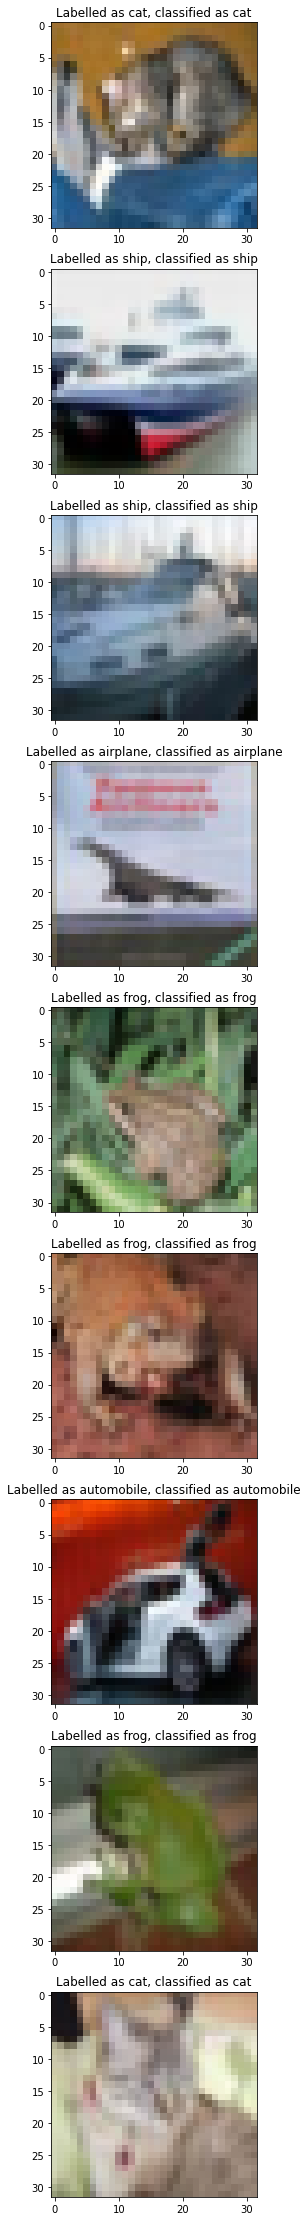

In [5]:
show_Cifar_validation_result(model, test)